In [1]:
from IPython import get_ipython
import logging
import numpy as np
from skimage import io
from skimage import color
from skimage import exposure
from skimage import img_as_ubyte
from skimage import transform
import tifffile

try:
    cv2.setNumThreads(0)
except:
    pass

logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]" \
                    "[%(process)d] %(message)s",
                    level=logging.ERROR)

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.volpy.volparams import volparams
from caiman.summary_images import local_correlations_movie_offline
from caiman.summary_images import mean_image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
%run unet.ipynb
from PIL import Image
import cv2
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

C:\anaconda3\envs\caiman\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#load movie
movie = 'W:/staff-groups/tnw/ist/do/projects/Neurophotonics/Brinkslab/Data/Safia/2048x1016 200 fps FOV10.TIF'
movie_array = tifffile.imread(movie)

In [3]:
#Display the movie
m_orig = cm.movie(np.array(movie_array, dtype=movie_array.dtype))

In [4]:
# Setup parameters for motion correction
max_shifts = (5, 5)  #maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  #create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  #overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3  #maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
border_nan = 'copy' 
frate = 500                      #movie frame rate
gSig_filt = (3, 3)               #size of gaussian filter to separate background from foreground

opts_dict = {
    'fnames': movie_array,
    'fr': frate,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = volparams(params_dict=opts_dict)

In [5]:
#cluster for fast processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

In [6]:
# Create a motion correction object with the specified parameters
mc = MotionCorrect(movie_array, dview = dview, **opts.get_group('motion'))
mc.motion_correct(save_movie=True)

In [16]:
m_rig = cm.load(mc.mmap_file)
m_rig = np.array(m_rig, dtype=movie_array.dtype)
m_rig = cm.movie(m_rig)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.98s/it]


In [7]:
# Memory mapping for fast processing
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0
fname_new = cm.save_memmap_join(mc.mmap_file, base_name='memmap_',
                           add_to_mov=border_to_0, dview=dview, n_chunks=10)

In [8]:
# Segmentation using U-Net
image = mean_image(mc.mmap_file[0], window = 1000, dview=dview)
image = (image-np.mean(image))/np.std(image) #normalizing the mean image. A common technique to scale the pixel values and improve the contrast in the image.

gaussian_blur = False ###
Cn = local_correlations_movie_offline(mc.mmap_file[0], fr=frate, window=frate*4, 
                                      stride=frate*4, winSize_baseline=frate, 
                                      remove_baseline=True, gaussian_blur=gaussian_blur,
                                      dview=dview).max(axis=0)#local correlations in the movie calculated. Correlation image obtained by taking the maximum correlation across all frames. 

img_corr = (Cn-np.mean(Cn))/np.std(Cn) #normalizing the correlation image.

summary_images = np.stack([image, image, img_corr], axis=0).astype(np.float32) 
#stacks the mean image and the correlation image into a single array along the first axis, effectively creating a 3-channel image. The duplication ([img, img, img_corr]) is done to match the format expected by the VolPy GUI.
image_mean_corr=summary_images.transpose([1, 2, 0])

In [9]:
unet = UNet(in_channels=3, out_classes=1)  
unet.load_state_dict(torch.load('unet.pth'))
unet.eval() 

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [10]:
image_mean_corr = np.clip(image_mean_corr, 0, 1)
img = Image.fromarray((image_mean_corr * 255).astype(np.uint8))

transform = transforms.Compose([
    transforms.Resize((109, 496)),  # Resize input image to match model's input size
    transforms.ToTensor(),
])

input_tensor = transform(img).unsqueeze(0)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

# Passing the input tensor through the model to get predictions
with torch.no_grad():
    output_mask = unet(input_tensor)

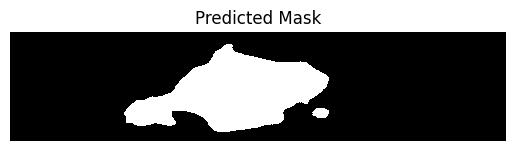

In [11]:
# mask generation
output_mask_np = output_mask.squeeze().cpu().numpy()
output_mask_inverted = 255 - output_mask_np

threshold = 255
output_mask_thresholded = (output_mask_inverted > threshold) * 255

plt.imshow(output_mask_thresholded, cmap='binary')
plt.title('Predicted Mask')
plt.axis('off') 
plt.show()

In [12]:
from skimage import transform
rgb_image_np = np.array(img)
new_ht = 109
new_width = 496
resized_image = transform.resize(rgb_image_np, (new_ht, new_width))
resized_image = Image.fromarray(np.uint8(resized_image * 255))

In [13]:
mask = np.array(output_mask_thresholded)
mask_np = mask.astype(np.uint8)
img_np = np.array(resized_image)

In [14]:
binary_mask = mask_np.copy()
binary_mask[binary_mask > 0] = 1
inverted_mask = 1 - binary_mask
mask_resized_inv = cv2.resize(inverted_mask, (m_rig.shape[2], m_rig.shape[1]))

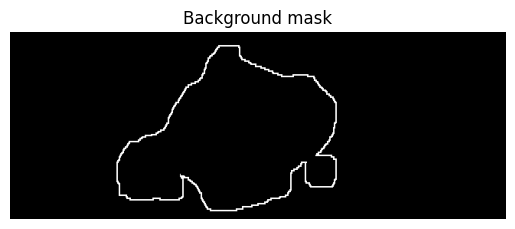

In [20]:
#sensitivity calculations
#dilating the mask 
kernel = np.ones((5, 5), np.uint8)
#mask_np_dilated_1 = cv2.dilate(inverted_mask, kernel, iterations=5)
mask_np_dilated_1 = cv2.dilate(mask_resized_inv, kernel, iterations=5)
#mask_np_dilated_2 = cv2.dilate(inverted_mask, kernel, iterations=4)
mask_np_dilated_2 = cv2.dilate(mask_resized_inv, kernel, iterations=4)

mask_bg = mask_np_dilated_1 - mask_np_dilated_2
mask_bg = 1-mask_bg

binary_mask_bg = mask_bg.copy()
binary_mask_bg[binary_mask_bg > 0] = 1


plt.imshow(binary_mask_bg, cmap = 'binary')
plt.axis('off')
plt.title('Background mask')
plt.show()

In [22]:
#overlay cell mask on motion corrected movie to get cell intensity

mean_intensities_cell = []

for i in m_rig:
    cell_mask = i * mask_np_dilated_2
    mean_intensity_cell = np.mean(cell_mask[mask_np_dilated_2>0])
    mean_intensities_cell.append(mean_intensity_cell)

In [23]:
#overlay b.g mask on motion corrected movie to get background intensity

mean_intensities_bg = []

for j in m_rig:
    bg_mask = j * binary_mask_bg
    mean_intensity_bg = np.mean(bg_mask[binary_mask_bg>0])
    mean_intensities_bg.append(mean_intensity_bg)

In [24]:
mean_intensities_segmented_cell_arr = np.array(mean_intensities_cell)
mean_intensities_bg_arr = np.array(mean_intensities_bg)

bg_corrected_signal = mean_intensities_segmented_cell_arr - mean_intensities_bg_arr

In [25]:
#for sHEK movies
#Photobleaching correction
#using interpolation
smoothed_intensities_speed = medfilt(mean_intensities_cell, kernel_size=1975)
smoothed_intensities_sensitivity = medfilt(bg_corrected_signal, kernel_size=1975)

In [26]:
subtracted_intensity_speed = mean_intensities_cell - smoothed_intensities_speed
normalized_intensity = bg_corrected_signal / smoothed_intensities_sensitivity

In [27]:
#Averaging the intensities
midpoint_speed = len(subtracted_intensity_speed) // 2
midpoint_sensitivity = len(normalized_intensity) // 2

if len(subtracted_intensity_speed) % 2 == 0:
    mean_of_lobes_speed = (subtracted_intensity_speed[:midpoint_speed] + subtracted_intensity_speed[midpoint_speed:]) / 2
else:
    mean_of_lobes_speed = (subtracted_intensity_speed[:midpoint_speed] + subtracted_intensity_speed[midpoint_speed+1:]) / 2

if len(normalized_intensity) % 2 == 0:
    mean_of_lobes_sensitivity = (normalized_intensity[:midpoint_sensitivity] + normalized_intensity[midpoint_sensitivity:]) / 2
else:
    mean_of_lobes_sensitivity = (normalized_intensity[:midpoint_sensitivity] + normalized_intensity[midpoint_sensitivity+1:]) / 2

In [28]:
frame_rate = 500
time_speed = [frame_num / frame_rate for frame_num in range(len(mean_of_lobes_speed))]
time_sensitivity =  [frame_num / frame_rate for frame_num in range(len(mean_of_lobes_sensitivity))]

In [29]:
#steady state fluorescence
time_arr = np.array(time_sensitivity)
signal_arr = np.array(mean_of_lobes_sensitivity)

start_time_ss = 0.54 #seconds
end_time_ss = 0.75 #seconds

start_index_ss = np.argmax(time_arr >= start_time_ss)
end_index_ss = np.argmax(time_arr >= end_time_ss)

fluorescence_ss_range = signal_arr[start_index_ss:end_index_ss]

ss_fluorescence = np.mean(fluorescence_ss_range)

In [30]:
sensitivity = ((ss_fluorescence - 1)/1)*100
sensitivity = np.abs(sensitivity)
print("Sensitivity of GEVI is ", str(sensitivity)[:5], "%")

Sensitivity of GEVI is  39.09 %


In [31]:
#speed calculations
#Low pass filter to remove noise
from scipy.signal import savgol_filter

window_size = 11
poly_order = 1 
mean_of_lobes_smoothed = savgol_filter(mean_of_lobes_speed, window_size, poly_order)

In [32]:
x = np.array(time_speed) 
y = mean_of_lobes_smoothed

x_data = x[(x >= 0.525) & (x <= 0.54)]
y_data = y[(x >= 0.525) & (x <= 0.54)]

gradient = np.gradient(y_data,x_data)

In [2]:
x_actual = np.array(time_speed) 
y_actual = mean_of_lobes_speed

if all(a > 0 for a in gradient):
    def biexponential(x, a, x1, b, x2):
        return a * np.exp((x / x1)) + b * np.exp((x / x2))

    x_subset = x_actual[(x_actual >= 0.515) & (x_actual <= 0.54)]
    y_subset = y_actual[(x_actual >= 0.515) & (x_actual <= 0.54)]
    popt, pcov = curve_fit(biexponential, x_subset, y_subset, maxfev = 500000)
    y_fit = biexponential(x_subset, *popt)

    plt.plot(x_subset, y_subset, label='Original Data')
    plt.plot(x_subset, y_fit, label='Fitted Curve', color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Change in Fluorescence (A.U.)')
    plt.legend()
    plt.show
    
    upswing_slow_constant = min([popt[1], popt[3]])
    upswing_fast_constant = max([popt[1], popt[3]])
    w = popt[0]/popt[2]
    ratio = w/(1+w)
    c = np.abs(ratio)
    if c < 0.1 or c == 1:
        speed = 1/upswing_fast_constant
        speed = np.abs(speed)
        print("Speed of GEVI is ", str(speed)[:5], "/seconds")
        print("Speed of GEVI calculated from fast time constant only")

    elif c > 1:
        speed = 1/upswing_slow_constant
        speed = np.abs(speed)
        print("Speed of GEVI is ", str(speed)[:5], "/seconds")
        print("Speed of GEVI calculated from slow time constant only")

    else: 
        speed = 1/((upswing_fast_constant * (1-c)) + (c * upswing_slow_constant))
        speed = np.abs(speed)
        print("Speed of GEVI is ", str(speed)[:5], "/seconds")
        print("Fast time constant has ", str((1-c)*100)[:5], "% contribution whereas slow time constant has ", str((c)*100)[:5], "% contribution to the speed calculation")
    
else:
    print("The GEVI is very fast")

NameError: name 'time_speed' is not defined

In [34]:
# Membrane intensity / cell intensity
# z-projected image of motion corrected movie

frs = []
for fr in m_rig:
    frs.append(fr)

fr_array = np.array(frs)
z_projection = np.mean(fr_array, axis = 0).astype(np.float32)

In [36]:
dilated_binary_mask = 1 - mask_np_dilated_2
#dilated_binary_mask_resized = cv2.resize(dilated_binary_mask, (z_projection.shape[1], z_projection.shape[0]))

In [37]:
#background subtraction in z_projected image
blur = cv2.bilateralFilter(z_projection,75,75,75)

In [38]:
cell_region = blur[dilated_binary_mask == 0]
mean_intensity_whole_cell = np.mean(cell_region)

In [39]:
contours, _ = cv2.findContours(dilated_binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_mask = np.zeros_like(dilated_binary_mask)
region = cv2.drawContours(contour_mask, contours, -1, (255), thickness=1)

In [40]:
membrane = blur[region == 255]
mean_intensity_membrane = np.mean(membrane)

In [42]:
intensity_ratio = mean_intensity_membrane / mean_intensity_whole_cell
print('mean intensity membrane / mean intensity of whole cell : ', str(intensity_ratio)[:5])

mean intensity membrane / mean intensity of whole cell :  0.523
